# Fitting neutralization curves
Here we describe how to use the :mod:class:`neutcurve.CurveFits` class to fit a set of :mod:class:`hillcurve.HillCurve` neutralization curves to data.

## Importing the necessary packages
First, import the necessary Python modules.
In addition to the `neutcurve` package itself, we also use [pandas](https://pandas.pydata.org/) to hold the data:

In [1]:
import urllib.request

import pandas as pd

import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE

Set some pandas display options:

In [2]:
pd.set_option('display.float_format', '{:.3g}'.format)

## The neutralization data to fit
Now we get example data to fit.
We use as our example the neutralization of variants A/WSN/1933 (H1N1) influenza by the broadly neutralizing antibody FI6v3 and strain-specific antibody H17-L19 from [Fig 6a,b of Doud et al (2018)](https://www.nature.com/articles/s41467-018-03665-3#Fig6).
These data in numerical form in a CSV file are [available here](https://github.com/jbloomlab/neutcurve/blob/master/docs/examples/data/Doud_et_al_2018-neutdata.csv).
We start by downloading these data and reading them into a pandas DataFrame:

In [3]:
fi6v3_datafile = ('https://raw.githubusercontent.com/jbloomlab/neutcurve/'
                  'master/docs/examples/data/Doud_et_al_2018-neutdata.csv')

with urllib.request.urlopen(fi6v3_datafile) as f:
    data = pd.read_csv(f)

Here are the first few lines of the data frame:

In [4]:
data.head()

,serum,virus,replicate,concentration,fraction infectivity
0,FI6v3,WT,1,0.000205,1.01
1,FI6v3,WT,1,0.000478,0.942
2,FI6v3,WT,1,0.00112,0.993
3,FI6v3,WT,1,0.0026,0.966
4,FI6v3,WT,1,0.00607,0.957


And here are the last few lines:

In [5]:
data.tail()

,serum,virus,replicate,concentration,fraction infectivity
427,H17-L19,V135T,3,0.386,1.02
428,H17-L19,V135T,3,0.9,1
429,H17-L19,V135T,3,2.1,0.959
430,H17-L19,V135T,3,4.9,0.991
431,H17-L19,V135T,3,11.4,0.747


As can be seen above, the data are organized into five columns, all of which must be present.
These columns are:
  - *serum*: the name of the serum (or antibody).
    FI6v3 and H17-L19 are actually antibodies, not sera--but :mod:class:`neutcurve.CurveFits` is set up to refer to things as serum.
  - *virus*: the name of the virus being neutralized by the serum.
  - *replicate*: the replicate label for the measurement. Although you can have just one replicate, it's good experimental practice to have several.
    All the replicates for a given virus / serum combination must have been measured at the same concentrations.
  - *concentration*: the concentration of the serum.
  - *fraction infectivity*: the fraction infectivity of the virus at this concentration of the serum measured in this replicate.
  
Note that the data are in [tidy form](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html); you must make your data frame tidy before you can analyze it with :mod:class:`neutcurve.CurveFits`. 

## Fitting the curves
Once you have the tidy data frame, it's easy to pass it to :mod:class:`neutcurve.CurveFits`.
We expect all of these antibodies to go to complete neutralization when they are effective, so we use the `fixbottom=0` argument (see :mod:class:`neutcurve.hillcurve.HillCurves` for more details about this option):

In [6]:
fits = neutcurve.CurveFits(data,
                           fixbottom=0,
                           )

Note that :mod:class:`neutcurve.CurveFits` has the same `fixtop` and `fixbottom` arguments as described for a :mod:class:`hillcurve.HillCurve` in the previous section; it also has arguments that all you to name the columns in data something else (for instance, you can set `serum_col='antibody'` if your data frame lists antibodies instead of sera).

Now we can look at the different sera for which we have fit curves:

In [7]:
fits.sera

['FI6v3', 'H17-L19']

We can also look at the viruses measured against each serum.
Here we do this for "serum" FI6v3:

In [8]:
for serum in fits.sera:
    print(f"Viruses measured against {serum}:")
    print(fits.viruses[serum])

Viruses measured against FI6v3:
['WT', 'K(-8T)', 'P80D', 'V135T', 'K280A', 'K280S', 'K280T', 'N291S', 'M17L-HA2', 'G47R-HA2']
Viruses measured against H17-L19:
['WT', 'V135T']


We can also look at the replicates for each serum and virus.
Here we just do that for serum *FI6v3* and virus *WT*.
See how in addition to the three replicates we have passed, there is also now an "average" replicate that is computed from the average of the other replicates:

In [9]:
fits.replicates[('FI6v3', 'WT')]

['1', '2', '3', 'average']

## Looking at a specific curve

We can use the :mod:class:`curvefits.CurveFits.getCurve` method to get the fit for a particular
serum / virus / replicate combination.
For instance, here we do that for *serum* FI6v3 versus *virus* WT, *replicate* 1.
We then plot the curve and get the IC50:

The IC50 is 0.0167


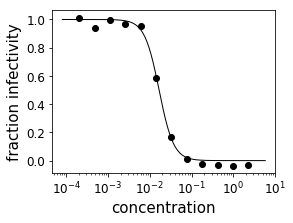

In [10]:
curve = fits.getCurve(serum='FI6v3', virus='WT', replicate='1')
print(f"The IC50 is {curve.ic50():.3g}")
fig, ax = curve.plot()

The :mod:class:`curvefits.CurveFits` also calculates the average and standard deviation of the measurements for each serum / virus, and fits them under a replicate name of "average".
So here is the fit to the average of the data for *serum* FI6v3 and *virus* WT.
Note how the plot now also shows error bars indicating the standard deviation:

The IC50 is 0.0195


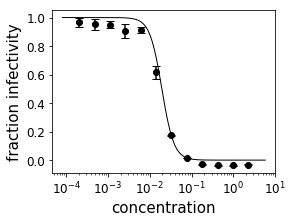

In [11]:
curve = fits.getCurve(serum='FI6v3', virus='WT', replicate='average')
print(f"The IC50 is {curve.ic50():.3g}")
fig, ax = curve.plot()

## Fit parameters for all curves
You can get the fit parameters for the curves using :meth:`neutcurve.curvefits.CurveFits.fitParams`.
By default, this just gets the fits for the average of the replicates.
The parameters are all of those fit by a :meth:`neutcurve.curvefits.HillCurve`, plus the IC50 in several forms to accurately represent interpolated IC50s (IC50 within range of data) versus IC50s where we can just get the bound from the upper or lower limits of the data:

In [12]:
fits.fitParams()

,serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,midpoint,slope,top,bottom
0,FI6v3,WT,average,3,0.0195,interpolated,0.0195,0.0195,3,1,0
1,FI6v3,K(-8T),average,3,0.0325,interpolated,0.0325,0.0325,2.9,1,0
2,FI6v3,P80D,average,3,0.0124,interpolated,0.0124,0.0124,2.3,1,0
3,FI6v3,V135T,average,3,0.0241,interpolated,0.0241,0.0241,2.09,1,0
4,FI6v3,K280A,average,3,0.0142,interpolated,0.0142,0.0142,3.18,1,0
5,FI6v3,K280S,average,3,0.0389,interpolated,0.0389,0.0389,2.9,1,0
6,FI6v3,K280T,average,3,0.0392,interpolated,0.0392,0.0392,2.33,1,0
7,FI6v3,N291S,average,3,0.106,interpolated,0.106,0.106,2.77,1,0
8,FI6v3,M17L-HA2,average,3,0.022,interpolated,0.022,0.022,2.69,1,0
9,FI6v3,G47R-HA2,average,3,0.0356,interpolated,0.0356,0.0356,3.32,1,0


Note that by default, :meth:`neutcurve.curvefits.CurveFits.fitParams` only returns the fitted params for the averages.
If you want to also return them for individual replicates, using the `average_only=False` argument, as in:

In [13]:
fits.fitParams(average_only=False).head()

,serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,midpoint,slope,top,bottom
0,FI6v3,WT,1,NaN,0.0167,interpolated,0.0167,0.0167,2.5,1,0
1,FI6v3,WT,2,NaN,0.019,interpolated,0.019,0.019,2.51,1,0
2,FI6v3,WT,3,NaN,0.0152,interpolated,0.0152,0.0152,1.88,1,0
3,FI6v3,WT,average,3,0.0195,interpolated,0.0195,0.0195,3,1,0
4,FI6v3,K(-8T),1,NaN,0.0308,interpolated,0.0308,0.0308,2.62,1,0


## Plotting the curves


### Plotting each replicate

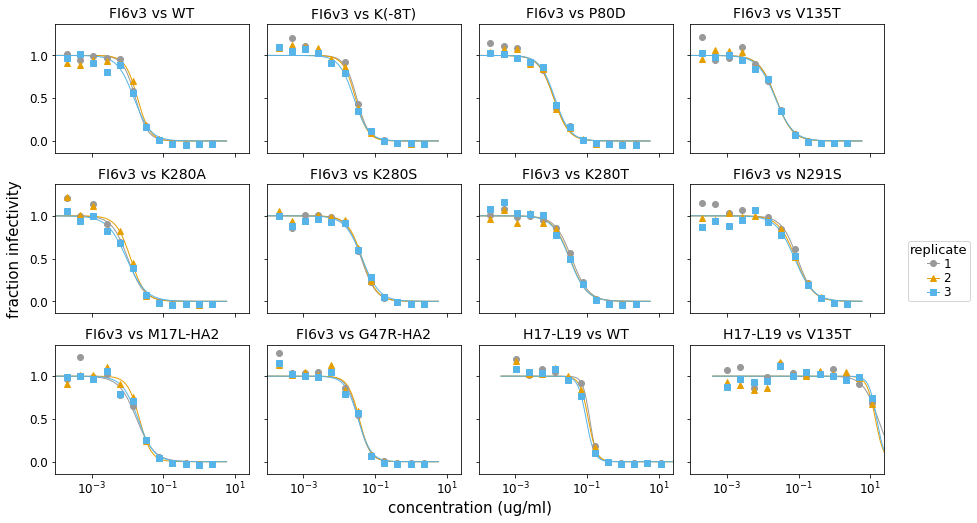

In [14]:
fig, axes = fits.plotReplicates(xlabel='concentration (ug/ml)')

### Customized plot arrangements
[Fig 6a,b of Doud et al (2018)](https://www.nature.com/articles/s41467-018-03665-3#Fig6).

We use the colors and markers defined in :mod:`neutcurve.colorschemes`

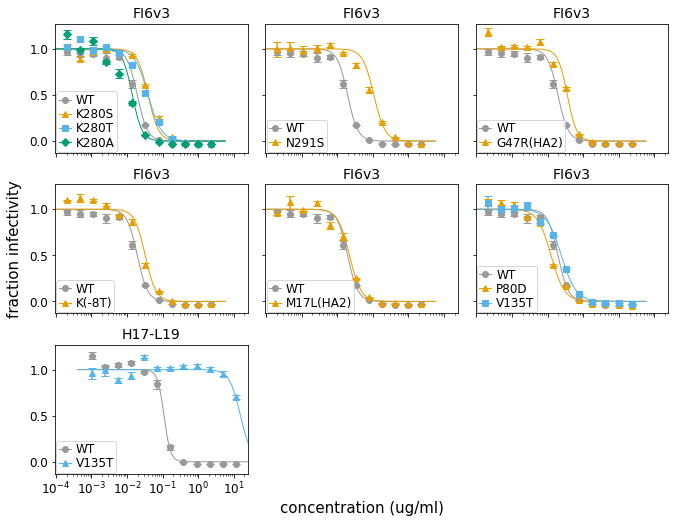

In [15]:
fig, axes = fits.plotGrid(
                {
                 # upper right: FI6v3 versus WT, K280S, K280T, K280A
                 (0, 0): ('FI6v3',
                          [{'serum': 'FI6v3', 'virus': 'WT',
                            'replicate': 'average', 'color': CBPALETTE[0],
                            'marker': CBMARKERS[0], 'label':'WT'},
                           {'serum': 'FI6v3', 'virus': 'K280S',
                            'replicate': 'average', 'color': CBPALETTE[1],
                            'marker': CBMARKERS[1], 'label':'K280S'},
                           {'serum': 'FI6v3', 'virus': 'K280T',
                            'replicate': 'average', 'color': CBPALETTE[2],
                            'marker': CBMARKERS[2], 'label':'K280T'},
                           {'serum': 'FI6v3', 'virus': 'K280A',
                            'replicate': 'average', 'color': CBPALETTE[3],
                            'marker': CBMARKERS[3], 'label':'K280A'},
                           ]
                          ),
                 # upper center: FI6v3 versus WT, N291S
                 (0, 1): ('FI6v3',
                          [{'serum': 'FI6v3', 'virus': 'WT',
                            'replicate': 'average', 'color': CBPALETTE[0],
                            'marker': CBMARKERS[0], 'label': 'WT'},
                           {'serum': 'FI6v3', 'virus': 'N291S',
                            'replicate': 'average', 'color': CBPALETTE[1],
                            'marker': CBMARKERS[1], 'label': 'N291S'},
                           ]
                          ),
                 # upper right: FI6v3 versus WT, G47R-HA2
                 (0, 2): ('FI6v3',
                          [{'serum': 'FI6v3', 'virus': 'WT',
                            'replicate': 'average', 'color': CBPALETTE[0],
                            'marker': CBMARKERS[0], 'label': 'WT'},
                           {'serum': 'FI6v3', 'virus': 'G47R-HA2',
                            'replicate': 'average', 'color': CBPALETTE[1],
                            'marker': CBMARKERS[1], 'label': 'G47R(HA2)'},
                           ]
                          ),
                 # middle right: FI6v3 versus WT, K(-8T)
                 (1, 0): ('FI6v3',
                          [{'serum': 'FI6v3', 'virus': 'WT',
                            'replicate': 'average', 'color': CBPALETTE[0],
                            'marker': CBMARKERS[0], 'label': 'WT'},
                           {'serum': 'FI6v3', 'virus': 'K(-8T)',
                            'replicate': 'average', 'color': CBPALETTE[1],
                            'marker': CBMARKERS[1], 'label': 'K(-8T)'},
                           ]
                          ),
                 # middle center: FI6v3 versus WT, M17L-HA2
                 (1, 1): ('FI6v3',
                          [{'serum': 'FI6v3', 'virus': 'WT',
                            'replicate': 'average', 'color': CBPALETTE[0],
                            'marker': CBMARKERS[0], 'label': 'WT'},
                           {'serum': 'FI6v3', 'virus': 'M17L-HA2',
                            'replicate': 'average', 'color': CBPALETTE[1],
                            'marker': CBMARKERS[1], 'label': 'M17L(HA2)'},
                           ]
                          ),
                 # middle right: FI6v3 versus WT, P80D, V135T
                 (1, 2): ('FI6v3',
                          [{'serum': 'FI6v3', 'virus': 'WT',
                            'replicate': 'average', 'color': CBPALETTE[0],
                            'marker': CBMARKERS[0], 'label': 'WT'},
                           {'serum': 'FI6v3', 'virus': 'P80D',
                            'replicate': 'average', 'color': CBPALETTE[1],
                            'marker': CBMARKERS[1], 'label': 'P80D'},
                           {'serum': 'FI6v3', 'virus': 'V135T',
                            'replicate': 'average', 'color': CBPALETTE[2],
                            'marker': CBMARKERS[2], 'label': 'V135T'},
                           ]
                          ),
                 # middle left: H17-L19 versus WT, V135T
                 (2, 0): ('H17-L19',
                          [{'serum': 'H17-L19', 'virus': 'WT',
                            'replicate': 'average', 'color': CBPALETTE[0],
                            'marker': CBMARKERS[0], 'label': 'WT'},
                           {'serum': 'H17-L19', 'virus': 'V135T',
                            'replicate': 'average', 'color': CBPALETTE[2],
                            'marker': CBMARKERS[1], 'label': 'V135T'},
                           ]
                          ),
                 },
                xlabel='concentration (ug/ml)',
                )